In [17]:
#!pip install --upgrade nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/persr18/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import random
import torch

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

questions_df = pd.read_csv('dataset/Questions.csv', nrows=500, encoding='ISO-8859-1')
answers_df = pd.read_csv('dataset/Answers.csv', nrows=500, encoding='ISO-8859-1')

Training on GPU!


In [12]:
from bs4 import BeautifulSoup
from html import unescape

def clean_text(text):
    if pd.isnull(text):
        return ''
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = unescape(text)
    return text

questions_df['CleanedTitle'] = questions_df['Title'].apply(clean_text)
questions_df['CleanedBody'] = questions_df['Body'].apply(clean_text)
questions_df['CleanedQuestion'] = questions_df['CleanedTitle'] + ' ' + questions_df['CleanedBody']
question_texts = questions_df['CleanedQuestion'].tolist()

answers_df['CleanedBody'] = answers_df['Body'].apply(clean_text)
answer_texts = answers_df['CleanedBody'].tolist()

combined_text = question_texts + answer_texts
combined_text = ' '.join(combined_text)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation)
lemma = nltk.stem.wordnet.WordNetLemmatizer()

def clean(doc):
    punc_free = "".join(ch for ch in doc if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.lower().split())
    return normalized

combined_cleaned_text = clean(combined_text).split()

trigrams = [([combined_cleaned_text[i], combined_cleaned_text[i + 1]], combined_cleaned_text[i + 2])
            for i in range(len(combined_cleaned_text) - 2)]

vocab = set(combined_cleaned_text)
vocab.add('<UNK>')
voc_len = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}

inp = []
tar = []
unk_idx = word_to_ix['<UNK>']
for context, target in trigrams:
    context_idxs = torch.tensor([word_to_ix.get(w, unk_idx) for w in context], dtype=torch.long)
    inp.append(context_idxs)
    targ = torch.tensor([word_to_ix.get(target, unk_idx)], dtype=torch.long)
    tar.append(targ)

/tmp/ipykernel_1003/1555905505.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/persr18/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/persr18/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)

hidden_size = 100
n_layers = 1
decoder = RNN(voc_len, hidden_size, voc_len, n_layers).to(device)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.015)
criterion = nn.CrossEntropyLoss()

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    total_loss = 0

    batch_size = 32
    num_batches = len(inp) // batch_size

    for i in range(num_batches):
        batch_inp = inp[i * batch_size:(i + 1) * batch_size]
        batch_tar = target[i * batch_size:(i + 1) * batch_size]
        loss = 0

        for c in range(len(batch_inp)):
            input_tensor = batch_inp[c].to(device)
            target_tensor = batch_tar[c].to(device)
            output, hidden = decoder(input_tensor, hidden)
            loss += criterion(output, target_tensor)

        loss.backward()
        decoder_optimizer.step()

        decoder.zero_grad()
        hidden = decoder.init_hidden()

        total_loss += loss.item()

    remaining = len(inp) % batch_size
    if remaining > 0:
        batch_inp = inp[num_batches * batch_size:]
        batch_tar = target[num_batches * batch_size:]
        loss = 0

        for c in range(len(batch_inp)):
            input_tensor = batch_inp[c].to(device)
            target_tensor = batch_tar[c].to(device)
            output, hidden = decoder(input_tensor, hidden)
            loss += criterion(output, target_tensor)

        loss.backward()
        decoder_optimizer.step()
        decoder.zero_grad()
        hidden = decoder.init_hidden()
        total_loss += loss.item()

    average_loss = total_loss / len(inp)
    return average_loss


 56s (2 40%) 9.1870]
 52s (4 80%) 9.1580]


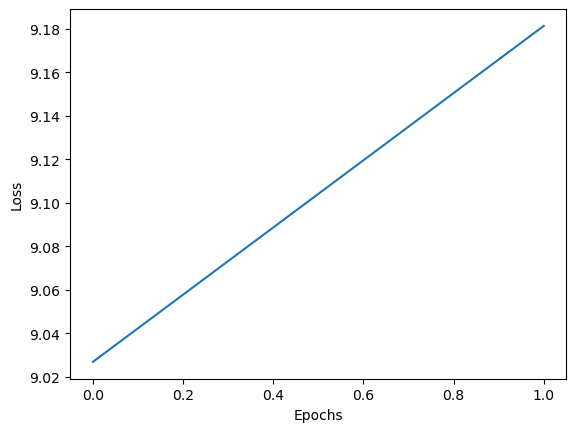

In [14]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

n_epochs = 5
print_every = 2
plot_every = 2
all_losses = []
loss_avg = 0

start = time.time()
for epoch in range(1, n_epochs + 1):
    loss = train(inp, tar)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
def evaluate(prime_str='this process', predict_len=20, temperature=0.1):
    hidden = decoder.init_hidden()
    default_idx = next(iter(word_to_ix.values()))
    prime_input = torch.tensor([word_to_ix.get(w, default_idx) for w in prime_str.lower().split()], dtype=torch.long).to(device)
    predicted_words = []

    for p in range(predict_len):
        if len(prime_input) < 2:
            inp = torch.cat((torch.tensor([default_idx], dtype=torch.long).to(device), prime_input))
        else:
            inp = prime_input[-2:]
        output, hidden = decoder(inp, hidden)

        output_dist = torch.nn.functional.softmax(output.view(-1) / temperature, dim=0)

        if torch.isnan(output_dist).any() or torch.isinf(output_dist).any():
            print("Warning: output_dist contains NaN or Inf values.")
            break

        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_word = ix_to_word[top_i.item()]
        predicted_words.append(predicted_word)
        prime_input = torch.cat((prime_input, torch.tensor([top_i.item()]).to(device)), 0)

    return ' '.join(predicted_words)


In [ ]:
print("Chatbot is ready! Type 'quit' to exit.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'quit':
        break
    response = evaluate(user_input, predict_len=20, temperature=0.1)
    print("Bot:", response)

Chatbot is ready! Type 'quit' to exit.


You:  what is python


Bot: to imap some use your proxypass tablet programmer func the full wacom operator bclassdict broken did the url to do


You:  what is photoshop


Bot: to use day1 sqrt sqrt of ability readily duplicate demonstrate pas seen intended proceed weekday import weekday controllersinitpy controllersinitpy the
